# Spec2Vec - spectra networking
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture the underlying molecular relationships between spectra.

One of the important envisioned use-cases for the Spec2Vec based spectra similarity measure, is **molecular networking**. Here we aim at clustering all spectra by building networks from nodes (=spectra) and their most prominent edges/connections (=most similar pairs of spectra).


## Notebook outline
0. Importing folders and packages
1. Import and filter MS-MS data from MGF file
2. Build networks...

In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_OUTPUT = ROOT + "\\Spec2Vec\\output_plots\\"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

# 1. Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [4]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json"
file_mgf = PATH_MS_DATA + "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


# 2. Load model and find most similar spectra

### Switch to Spec2Vec core functionality

In [6]:
# Import Spec2Vec functions
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile
import MS_similarity_classical as MS_sim_classic

# Import additional functions
from scipy import spatial

### Create SimilarityMeasures object

In [9]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  116344


### Load pretrained Spec2Vec model

In [10]:
file_model_word2vec = PATH_SAVE_MODEL + 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100_TEMP_15.model'
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [11]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents.0998  documents.  documents.  of  10998  documents. 10998  documents.  documents. documents. 10998  documents.10998  documents. of  10998  documents.  documents.

### Calculate similarities between all spectra and get top 25 for each spectrum

In [12]:
MS_library.get_centroid_similarity(num_hits=25, method='cosine')

Calculated distances between  10998  documents.


In [15]:
MS_library.list_similars_ctr_idx[0]

array([   0,  398, 1158,  383,  340,  343,  292,  650,  376,  352,  348,
       1933, 1930, 1931,   19,  285,  627,  581,  612,  379,  469, 1156,
        288,  322, 1932])

In [14]:
MS_library.list_similars_ctr[0]

array([1.        , 0.7166732 , 0.68961962, 0.68821332, 0.68798576,
       0.68034398, 0.67874722, 0.6663347 , 0.66539644, 0.66169041,
       0.66136296, 0.66124369, 0.64941635, 0.64821189, 0.64763228,
       0.63776666, 0.63374876, 0.62639644, 0.62429432, 0.62029123,
       0.61802026, 0.615745  , 0.61504999, 0.61463586, 0.61122527])

In [57]:
link_method = 'single'
max_links = 10
cutoff = 0.9 #0.7

list_similars_idx = MS_library.list_similars_ctr_idx
list_similars = MS_library.list_similars_ctr
dimension = list_similars_idx.shape[0]

# Initialize network graph
import networkx as nx
MSnet = nx.Graph()               
MSnet.add_nodes_from(np.arange(0, dimension))   

for i in range(0, dimension):      
    idx = np.where(list_similars[i,:] > cutoff)[0][:max_links]
    if link_method == "single":
        new_edges = [(i, int(list_similars_idx[i,x]), float(list_similars[i,x])) for x in idx if list_similars_idx[i,x] != i]
    elif link_method == "mutual":
        new_edges = [(i, int(list_similars_idx[i,x]), float(list_similars[i,x])) for x in idx if list_similars_idx[i,x] != i if i in list_similars_idx[x,:]]
    else:
        print("Link method not kown")
    MSnet.add_weighted_edges_from(new_edges)

In [23]:
new_edges

[(10997, 10996, 0.9440537946305146),
 (10997, 4873, 0.8130197878533513),
 (10997, 5149, 0.804400561065505),
 (10997, 4188, 0.7892092240245423),
 (10997, 3919, 0.7546718216031021),
 (10997, 5402, 0.7481105810136729),
 (10997, 4831, 0.7440869531120033),
 (10997, 4219, 0.742788225152474),
 (10997, 9423, 0.7214996334119242)]

In [29]:
checks = nx.minimum_edge_cut(MSnet, 1, 9)

In [35]:
MSnet[321]

AtlasView({3: {'weight': 0.7632902287461478}, 344: {'weight': 0.9214874227268695}, 1933: {'weight': 0.9006804216104543}, 485: {'weight': 0.8796278180166391}, 316: {'weight': 0.858135234499224}, 505: {'weight': 0.856957182398646}, 516: {'weight': 0.8505401528392674}, 1930: {'weight': 0.8340249259403394}, 322: {'weight': 0.8287879648999299}, 349: {'weight': 0.8268033302659082}})

In [28]:
MSnet.edge_subgraph

EdgeView([(0, 398), (1, 9), (1, 6137), (1, 4837), (1, 1432), (1, 5865), (1, 6391), (1, 1531), (1, 6938), (1, 5856), (1, 196), (1, 2164), (1, 2167), (1, 2589), (2, 11), (2, 10528), (2, 10526), (2, 6480), (2, 8), (2, 6008), (2, 5702), (2, 6009), (2, 6700), (3, 321), (3, 4), (3, 485), (3, 650), (3, 344), (3, 374), (3, 555), (3, 415), (3, 1932), (4, 1932), (4, 1931), (4, 1933), (4, 1930), (4, 292), (4, 340), (4, 352), (4, 285), (4, 383), (5, 14), (5, 17), (5, 8168), (5, 9955), (5, 1039), (5, 9538), (5, 8961), (5, 928), (5, 12), (5, 13), (5, 67), (5, 1180), (5, 2031), (5, 5633), (5, 6706), (5, 8040), (5, 8045), (5, 8707), (5, 8928), (5, 9070), (5, 9166), (5, 9167), (5, 9461), (6, 8038), (6, 8033), (6, 1958), (6, 928), (6, 9016), (6, 8034), (6, 905), (6, 17), (6, 1755), (6, 10790), (7, 6756), (7, 2789), (7, 5659), (7, 5654), (7, 5645), (7, 1397), (7, 5266), (7, 10821), (8, 10528), (8, 3880), (8, 6700), (8, 10526), (8, 6973), (8, 5605), (8, 6442), (8, 2163), (8, 11), (8, 2165), (9, 1432), (9,

In [36]:
Gc = max(nx.connected_component_subgraphs(MSnet), key=len)

In [72]:
print(nx.node_connected_component(MSnet, 5)) 

{8704, 8961, 1281, 8707, 9984, 5, 9731, 9862, 6405, 905, 5253, 907, 12, 13, 14, 1039, 908, 17, 4750, 3986, 1036, 2197, 9750, 23, 151, 1303, 282, 2198, 2574, 27, 928, 9633, 932, 10285, 4910, 9007, 2353, 7601, 9016, 7484, 4928, 9538, 67, 1988, 3601, 9166, 79, 9167, 81, 1752, 9050, 1755, 1754, 8417, 8033, 9955, 8034, 994, 10086, 8038, 8168, 2024, 8174, 2031, 9967, 1010, 8949, 889}


In [73]:
graphs = list(nx.connected_component_subgraphs(MSnet))
len(graphs[5].edges)

325

In [62]:
print(nx.triangles(MSnet,5))

31


In [99]:
print(nx.triangles(graphs[4]))

{642: 6, 1156: 10, 4: 0, 1158: 58, 1930: 32, 1931: 32, 1932: 10, 1933: 32, 650: 24, 398: 51, 285: 1, 292: 75, 549: 6, 1584: 0, 570: 34, 321: 0, 581: 1, 1356: 0, 591: 6, 592: 6, 340: 64, 343: 48, 344: 0, 348: 37, 352: 68, 368: 3, 627: 30, 376: 40, 637: 6, 383: 52}


In [98]:
checks = nx.minimum_edge_cut(graphs[4])
checks

{(321, 1933)}

In [88]:
MSnet[79]

AtlasView({23: {'weight': 0.9374692342269866}, 928: {'weight': 0.928017400899956}, 9955: {'weight': 0.9228089363421861}, 9050: {'weight': 0.9223641487700928}, 9016: {'weight': 0.9220000826367285}, 8961: {'weight': 0.9172047174780669}, 2024: {'weight': 0.9169655328632225}, 908: {'weight': 0.9159440901594007}, 9538: {'weight': 0.9153876380055741}, 81: {'weight': 0.9059722900354199}, 282: {'weight': 0.9039079073243937}, 932: {'weight': 0.9147859953609981}, 9166: {'weight': 0.9007636573575837}})

In [103]:
nodes = list(graphs[4].nodes)
print(nodes)

[642, 1156, 4, 1158, 1930, 1931, 1932, 1933, 650, 398, 285, 292, 549, 1584, 570, 321, 581, 1356, 591, 592, 340, 343, 344, 348, 352, 368, 627, 376, 637, 383]


In [111]:
import numpy as np
np.random.choice(nodes,2, replace=False)


376

# Removing links:
## Find single links that are connecting (sub)clusters

In [178]:
a = np.array(graphs[4].nodes)
new_array = np.array(np.meshgrid(a,a)).T
remove_diagonal = np.array([(i*new_array.shape[0] + i) for i in range(new_array.shape[0])])
#new_array =new_array.reshape(-1,2)
new_array = np.delete(new_array.reshape(-1,2), remove_diagonal, axis=0)
new_array

array([[ 642, 1156],
       [ 642,    4],
       [ 642, 1158],
       ...,
       [ 383,  627],
       [ 383,  376],
       [ 383,  637]])

In [183]:
choices = np.random.choice(np.arange(new_array.shape[0]), 10, replace=False)
choices

array([293, 768, 659, 687, 521,  31, 392,  82, 424, 114])

In [185]:
test = new_array[choices,:]
for t in test:
    print(t)

[ 285 1158]
[627 570]
[344 343]
[348 340]
[1356  383]
[1156 1158]
[1584  581]
[  4 368]
[570 592]
[1158  637]


In [187]:
def sample_cuts(graph,
                max_steps = 1000,
                max_cuts = 1):
    
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    
    nodes = np.array(graph.nodes)
    pairs = np.array(np.meshgrid(nodes, nodes)).T
    remove_diagonal = np.array([(i*num_nodes + i) for i in range(num_nodes)])
    pairs = np.delete(pairs.reshape(-1,2), remove_diagonal, axis=0)
    
    sampled_cuts = []
    if pairs.shape[0] < max_steps:
        max_steps = pairs.shape[0]
    else:
        choices = np.random.choice(np.arange(new_array.shape[0]), max_steps, replace=False)
        pairs = pairs[choices,:]
        
    for pair in pairs:
        cuts = nx.minimum_edge_cut(graph, pair[0], pair[1])
        if len(cuts) <= max_cuts:
            sampled_cuts.append(cuts)
            
    return sampled_cuts

In [190]:
test_cuts = sample_cuts(graphs[4],
                max_steps = 1000,
                max_cuts = 2)

In [191]:
test_cuts

[{(637, 1156)},
 {(1932, 4)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1584)},
 {(637, 1156)},
 {(1933, 321)},
 {(637, 1156)},
 {(637, 1356)},
 {(637, 1156)},
 {(637, 1156)},
 {(321, 344)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(637, 1156)},
 {(1156, 637)},
 {(1932, 4)},
 {(292, 285), (348, 285)},
 {(1156, 637)},
 {(637, 1584)},
 {(1933, 321)},
 {(398, 581), (650, 581)},
 {(637, 1356)},
 {(1156, 637)},
 {(1156, 637)},
 {(321, 344)},
 {(1156, 637)},
 {(1156, 637)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(1156, 637)},
 {(637, 1584)},
 {(4, 1932)},
 {(1933, 321)},
 {(4, 1932)},
 {(637, 1356)},
 {(1156, 637)},
 {(1156, 637)},
 {(4, 1932)},
 {(4, 1932)},
 {(321, 344)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},
 {(4, 1932)},

In [139]:

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 


In [140]:
test1 = [list(x)[0] for x in test]

test_sorted = []
for (x,y) in test1:
    #x,y = test
    if x > y:
        test_sorted += [(y,x)]
    else:
        test_sorted += [(x,y)]    
        
most_frequent(test_sorted)

(637, 1156)

In [105]:
nx.minimum_edge_cut(graphs[4],nodes[0], 592)#nodes[1])

{(549, 592), (591, 592), (637, 592), (642, 592)}

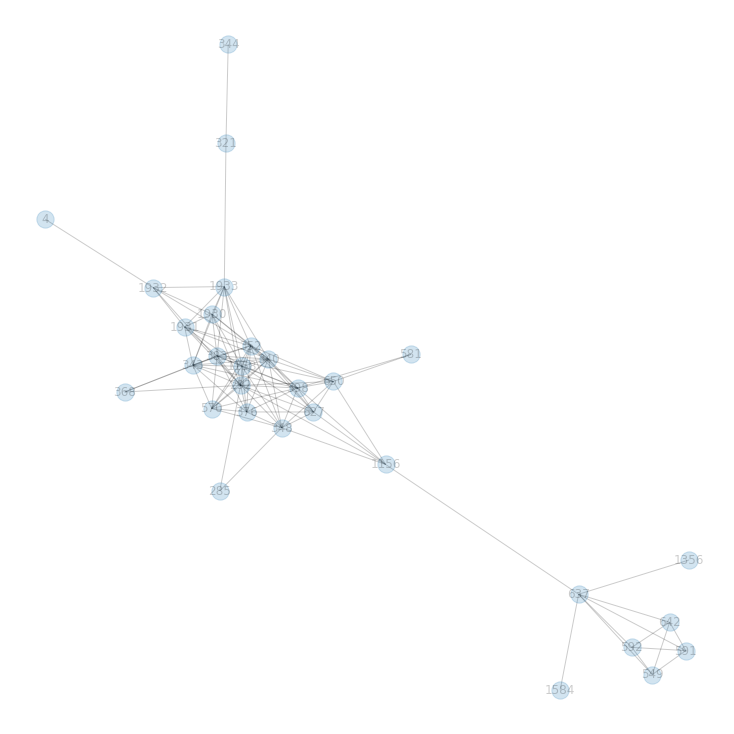

In [97]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
nx.draw(graphs[4], markersize=5, alpha=0.2, with_labels = True)

In [141]:
cutsets = list(nx.all_node_cuts(graphs[4]))
cutsets

[{1933}, {637}, {1156}, {1932}, {321}]

In [142]:
connectivities = nx.all_pairs_node_connectivity(graphs[4])

In [150]:
connectivities[642]

{1156: 1,
 4: 1,
 1158: 1,
 1930: 1,
 1931: 1,
 1932: 1,
 1933: 1,
 650: 1,
 398: 1,
 285: 1,
 292: 1,
 549: 4,
 1584: 1,
 570: 1,
 321: 1,
 581: 1,
 1356: 1,
 591: 4,
 592: 4,
 340: 1,
 343: 1,
 344: 1,
 348: 1,
 352: 1,
 368: 1,
 627: 1,
 376: 1,
 637: 4,
 383: 1}